In [2]:
import os
import pickle
import random
import glob
from glob import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
import pickle


import click



from joblib import delayed, Parallel
import random


from scipy import ndimage
import pydicom
from skimage import exposure

base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
os.listdir(base_url)

import keras
from keras.models import model_from_json
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 


from keras.preprocessing import image
import albumentations as A



from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
train_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
dcm_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [12]:
train_df = pd.read_csv(f'{base_url}/stage_2_train.csv').drop_duplicates()
train_df['ImageID'] = train_df['ID'].str.slice(stop=12)
train_df['Diagnosis'] = train_df['ID'].str.slice(start=13)
train_labels = train_df.pivot(index="ImageID", columns="Diagnosis", values="Label")
train_labels.head()

Diagnosis,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ImageID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [13]:
train_metadata = pd.read_parquet(f'{base_url}/train_metadata.parquet.gzip')
test_metadata = pd.read_parquet(f'{base_url}/test_metadata.parquet.gzip')

train_metadata["Dataset"] = "train"
test_metadata["Dataset"] = "test"

train_metadata = train_metadata.join(train_labels)

metadata = pd.concat([train_metadata, test_metadata], sort=True)
metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False)
metadata.sort_values(['PatientID','ImagePositionPatient_2'],inplace=True)
metadata.drop(['ID_6431af929'],inplace = True)

In [14]:
metadata.head()

,BitsAllocated,BitsStored,Columns,Dataset,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,...,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,
ID_45785016b,16,16,512,train,15,1.0,0.0,0.0,0.0,0.993572,...,,ID_66929e09d4,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_37f32aed2,16,16,512,train,15,1.0,0.0,0.0,0.0,0.993572,...,,ID_66929e09d4,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_1b9de2922,16,16,512,train,15,1.0,0.0,0.0,0.0,0.993572,...,,ID_66929e09d4,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_d61a6a7b9,16,16,512,train,15,1.0,0.0,0.0,0.0,0.993572,...,,ID_66929e09d4,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_406c82112,16,16,512,train,15,1.0,0.0,0.0,0.0,0.993572,...,,ID_66929e09d4,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
test_df = metadata[metadata['Dataset'] == 'test'].iloc[:,:-6].drop(['Dataset'], axis= 1)

In [16]:
train_df = metadata[metadata['Dataset'] == 'train'].drop(['Dataset'],axis=1)

In [17]:
train_y =  train_df[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']]
train_y.shape

(752802, 6)

In [126]:
train_df.shape

(752802, 35)

In [66]:
train_df.PatientID.nunique()

18938

# Dividing dataset into K-fold with equal patientID

In [4]:
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

In [61]:
df.head()

ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
752798   ID_ffff82e46     0        0                0                0   
752799   ID_ffff922b9     1        0                0                1   
752800   ID_ffffb670a     1        0                0                0   
752801   ID_ffffcbff8     0        0                0                0   
752802   ID_fffff9393     0        0                0                0   

                               \
Subtype subarachnoid subdural   
752798             0        0   
752799             0        0   
752800             1        0   
752801             0        0   
752802             0        0   

                                                  filepath    PatientID  \
Subtype                                                                   
752798   /home/ubuntu/kaggle/rsna-intracranial-hemorrha...  ID_a85c9d08   
752799   /home/ubuntu/kaggle/rsna-intracranial-hemorrha...  ID_5964c5e5   
752800   /home/ubuntu/kaggle/rsna-intracranial-hemorrha...  ID_4f7414e4   
752801   /home/ubuntu/kaggle/rsna-intracranial-hemorrha...  ID_a5382712   
752802   /home/ubuntu/kaggle/rsna-intracranial-hemorrha...  ID_41db05df   

               StudyID       SeriesID  
Subtype                                
752798   ID_eca4bf46ac  ID_3ef9b97743  
752799   ID_b47ca0ad05  ID_6d2a9b2810  
752800   ID_ffb2e70ba3  ID_87b33b4a10  
752801   ID_ff0ba45814  ID_bd174db91c  
752802   ID_7c887292d5  ID_dff8d8efd5

# Distribution of number of CT-Scan for Each PatientID

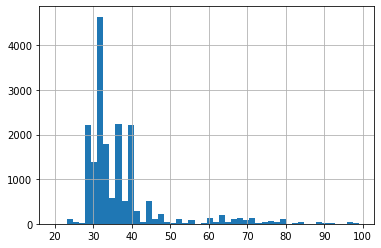

In [6]:
tmp = df["PatientID"].value_counts()
tmp[tmp<100].hist(bins=50);

In [10]:
patient_id_train = set(df["PatientID"].unique())
print(len(patient_id_train))

18938


In [58]:
train = train_df[['SOPInstanceUID','PatientID','any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]
train.reset_index(inplace=True)
train.head()

,Image,SOPInstanceUID,PatientID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_45785016b,ID_45785016b,ID_0002cd41,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_37f32aed2,ID_37f32aed2,ID_0002cd41,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_1b9de2922,ID_1b9de2922,ID_0002cd41,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_d61a6a7b9,ID_d61a6a7b9,ID_0002cd41,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_406c82112,ID_406c82112,ID_0002cd41,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
IGNORE_IDS = ['ID_6431af929']
print(train.shape)
train = train[~train['SOPInstanceUID'].isin(IGNORE_IDS)]
print(train.shape)

(752802, 9)
(752802, 9)


In [60]:
patient_id = train["PatientID"].unique() 
print(patient_id.shape) 

(18938,)


In [55]:
from sklearn.model_selection import KFold

seed = 2020
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed) # StratifiedKFold

fold = 0
for train_index, valid_index in kf.split(patient_id):
    df_train = train[train["PatientID"].isin(patient_id[train_index])]
    df_valid = train[train["PatientID"].isin(patient_id[valid_index])]
    
    df_train.to_csv("train_{}.csv".format(fold), index=None)
    df_valid.to_csv("valid_{}.csv".format(fold), index=None)
    
    fold += 1
    print(df_valid.shape)

(151865, 10)
(148063, 10)
(151306, 10)
(150597, 10)
(150971, 10)


In [56]:
df_train

,Image,SOPInstanceUID,PatientID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,set
36,ID_138d275c8,ID_138d275c8,ID_00054f3f,0.0,0.0,0.0,0.0,0.0,0.0,0
37,ID_447fa09d9,ID_447fa09d9,ID_00054f3f,0.0,0.0,0.0,0.0,0.0,0.0,0
38,ID_0f1298f68,ID_0f1298f68,ID_00054f3f,0.0,0.0,0.0,0.0,0.0,0.0,0
39,ID_c24918b79,ID_c24918b79,ID_00054f3f,0.0,0.0,0.0,0.0,0.0,0.0,0
40,ID_c0005a263,ID_c0005a263,ID_00054f3f,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
752797,ID_72e823e2c,ID_72e823e2c,ID_fffc2bd6,0.0,0.0,0.0,0.0,0.0,0.0,0
752798,ID_4184c4f03,ID_4184c4f03,ID_fffc2bd6,0.0,0.0,0.0,0.0,0.0,0.0,0
752799,ID_a8aca4f40,ID_a8aca4f40,ID_fffc2bd6,0.0,0.0,0.0,0.0,0.0,0.0,0
752800,ID_716b72762,ID_716b72762,ID_fffc2bd6,0.0,0.0,0.0,0.0,0.0,0.0,0
